In [64]:
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs|
import tensorflow_datasets as tfds # to load training data
import keras
import pandas as pd
from keras import backend
from tensorflow.keras import Model, initializers, regularizers, constraints
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Reshape, Bidirectional, Dense, Input, Dropout, LeakyReLU, Concatenate, PReLU, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt 
from math import sqrt
from google.colab import drive
import csv
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
inputs = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/AllVariables.csv")

keys = []
for it in inputs:
    keys.append(it)
    
distribution = [4, 9, 25, 26] #horrible design

number_of_tests = len(inputs[keys[0]])


In [66]:
input_short_term = []
input_long_term = []
output = []

for i in range(number_of_tests):
    instance = []
    if pd.isna(inputs[keys[0]][i]):
        continue
    for j in range(distribution[0], distribution[1]):         
        instance.append(round(float(inputs[keys[j]][i])/100, 3))

    input_short_term.append(instance)
    instance = []
    for j in range(distribution[1], distribution[2]):
        instance.append(round(float(inputs[keys[j]][i])/100, 3))
    #for j in range(distribution[3], distribution[4]):
    #    instance.append(float(inputs[keys[j]][i])/100)
    input_long_term.append(instance)

    output.append(float(inputs[keys[distribution[3] - 1]][i])/100)


In [67]:
training_input_short_term = []
training_input_long_term = []
training_output = []

testing_input_short_term = []
testing_input_long_term = []
testing_output = []

for i in range(8):
    for j in range(13):
            training_input_short_term.append(input_short_term[j])
            training_input_long_term.append(input_long_term[j])
            training_output.append(output[j])
    del input_short_term[:13]
    del input_long_term[:13]
    del output[:13]

        #training_input_short_term = np.delete(input_short_term, j)
    for k in range(1):
        testing_input_short_term.append(input_short_term[k])
        testing_input_long_term.append(input_long_term[k])
        testing_output.append(output[k])
    del input_short_term[0]
    del input_long_term[0]
    del output[0] 

In [68]:
# print(len(training_input_short_term))
# print(len(training_input_long_term))
# print(len(training_input_long_term))

# print(len(testing_input_short_term))
# print(len(testing_input_long_term))
# print(len(testing_output))

# print(training_input_long_term)

In [69]:
lVLabel = ["Capital_Investment_test", "Labor_Force_Participation_test", "Fixed_Broadband_test",
          "RandD_test", "Property_Rights_test", "Freedom_From_Corruption_test", "Fiscal_Freedom_test", "Business_Freedom_test",
          "Labor_Freedom_test", "Monetary_Freedom_test", "Trade_Freedom_test", "Investment_Freedom_test", "Financial_Freedom_test",
          "Economic_Freedom_Overall_test", "Pop_Above_65_test", "Savings_As_GDP_test"]

num_long_term_variable = len(lVLabel)

trainLV = [[] for i in range(num_long_term_variable)]

testLV  = [[] for i in range(num_long_term_variable)]

In [70]:

for i in range(len(training_input_long_term)):
    for j in range(num_long_term_variable):
        trainLV[j].append(training_input_long_term[i][j])
        
for i in range(num_long_term_variable):
    trainLV[i] = np.array(trainLV[i])

In [71]:

for i in range(len(testing_input_long_term)):
    for j in range(num_long_term_variable):
        testLV[j].append(training_input_long_term[i][j])

for i in range(num_long_term_variable):
    testLV[i] = np.array(testLV[i])

In [72]:
training_input_short_term = np.array(training_input_short_term)
training_input_long_term = np.array(training_input_long_term)
training_output = np.array(training_output)

testing_input_short_term = np.array(testing_input_short_term)
testing_input_long_term = np.array(testing_input_long_term)
testing_output = np.array(testing_output)


In [111]:
short_term_input1 = Input(shape=(5,))
short_term_input2 = Input(shape=(5,))
long_term_input1 = Input(shape=(16,))

x1 = Dense(50)(short_term_input1)
x1 = LeakyReLU(0.2)(x1)
x1 = Dropout(0.35)(x1)

x1 = Dense(50)(x1)
x1 = LeakyReLU(0.2)(x1)
x1 = Dropout(0.5)(x1)

x1 = Dense(50)(x1)
x1 = LeakyReLU(0.2)(x1)

con1 = Concatenate(axis=1)([x1, short_term_input2, long_term_input1])
con1 = Dropout(0.35)(con1)

con1 = Dense(71, activation = "relu")(con1)
con1 = Dropout(0.2)(con1)

con1 = Reshape(target_shape = (1, 71))(con1)

con1 = LSTM(100, return_sequences = True)(con1)
con1 = Dropout(0.2)(con1)

con1 = LSTM(100, return_sequences = True)(con1)
con1 = Dropout(0.35)(con1)

con1 = LSTM(200, return_sequences = True)(con1)
con1 = Dropout(0.35)(con1)
con1 = LSTM(100, return_sequences = True)(con1)
con1 = LSTM(1)(con1)

x2 = Dense(1, activation = None)(long_term_input1)
x2 = Reshape(target_shape= (1, 1))(x2)
x2 = LSTM(100, return_sequences = True)(x2)
x2 = LSTM(1)(x2)

con2 = Concatenate(axis=1)([con1, x2]) 

output = Dense(1, activation = None)(con2)

SingleLongTermmodel = Model(inputs=[short_term_input1, short_term_input2, long_term_input1], outputs=output)
SingleLongTermmodel.summary()
SingleLongTermmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mae', metrics = [tf.keras.metrics.RootMeanSquaredError()])

# count = 0
# top = ["Long term variable", "MAE"]
# output_list = []
# for item in trainLV:
#   print(lVLabel[count])
#   history = SingleLongTermmodel.fit([training_input_short_term, training_input_short_term, item], training_output, epochs = 40, batch_size = 3, verbose=0)
#   history2 = SingleLongTermmodel.evaluate([testing_input_short_term, testing_input_short_term, testLV[count]], testing_output, batch_size=3, verbose=1)
#   output_list.append([lVLabel[count], round(history2[0], 4)*100])
#   count+=1

# with open('/content/gdrive/My Drive/Colab Notebooks/FinalResults.csv', 'w', newline='') as results_file:
#     writer = csv.writer(results_file)
#     writer.writerow(top)
#     writer.writerows(output_list)
#     count+=1

# For easy access
# training_input_short_term
# training_input_long_term

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 50)           300         input_16[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 50)           0           dense_30[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 50)           0           leaky_re_lu_15[0][0]             
____________________________________________________________________________________________

In [112]:
# 0.0074 * 100 = 0.74
training_pred1, training_pred2, training_pred3 = training_input_short_term, training_input_short_term, training_input_long_term
y_output = training_output
history = SingleLongTermmodel.fit([training_pred1, training_pred2, training_pred3], y_output, epochs = 120, batch_size = 3, verbose=1)

Epoch 1/120
35/35 [==============================] - 11s 13ms/step - loss: 0.0223 - root_mean_squared_error: 0.0294
Epoch 2/120
35/35 [==============================] - 0s 13ms/step - loss: 0.0159 - root_mean_squared_error: 0.0204
Epoch 3/120
35/35 [==============================] - 0s 12ms/step - loss: 0.0204 - root_mean_squared_error: 0.0253
Epoch 4/120
35/35 [==============================] - 0s 12ms/step - loss: 0.0180 - root_mean_squared_error: 0.0230
Epoch 5/120
35/35 [==============================] - 0s 13ms/step - loss: 0.0196 - root_mean_squared_error: 0.0278
Epoch 6/120
35/35 [==============================] - 0s 12ms/step - loss: 0.0202 - root_mean_squared_error: 0.0255
Epoch 7/120
35/35 [==============================] - 0s 13ms/step - loss: 0.0196 - root_mean_squared_error: 0.0236
Epoch 8/120
35/35 [==============================] - 0s 13ms/step - loss: 0.0178 - root_mean_squared_error: 0.0236
Epoch 9/120
35/35 [==============================] - 0s 13ms/step - loss: 0.021

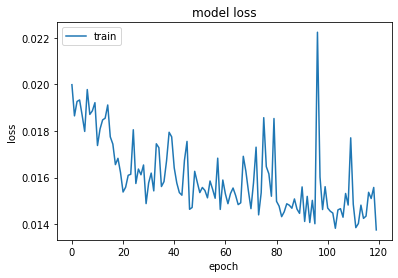

3/3 [==============================] - 2s 7ms/step - loss: 0.0073 - root_mean_squared_error: 0.0090


Text(0, 0.5, 'Percentage in real GDP change')

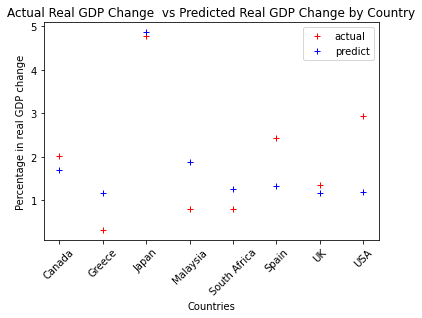

In [113]:
def print_loss_graph(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

print_loss_graph(history)
testing_st1,testing_st2, testing_lt1, testing_outp = testing_input_short_term, testing_input_short_term, testing_input_long_term, testing_output

y2 = SingleLongTermmodel.evaluate(x=[testing_st1, testing_st2, testing_lt1],y=testing_output, batch_size=3, verbose=1)

#testing_pred1, testing_pred2, testing_pred3 = testing_input_short_term[k/13], testing_input_short_term[k/13], testing_input_long_term[k/13]
#print(testing_pred1)
plt.plot(testing_output*100, 'r+')
X = SingleLongTermmodel.predict(x=[testing_input_short_term, testing_input_short_term, testing_input_long_term])
plt.plot(X*100, 'b+')
plt.legend(['actual', 'predict'])
plt.xticks(np.arange(start = 0, stop = 8), ['Canada', 'Greece', 'Japan', 'Malaysia', 'South Africa', 'Spain', 'UK', 'USA'], rotation = 45)
plt.title("Actual Real GDP Change  vs Predicted Real GDP Change by Country")
plt.xlabel("Countries")
plt.ylabel("Percentage in real GDP change")
# x = np.arange(start=2005, stop=2018, step=1)

# fig = plt.figure()
# ax = plt.subplot(111)
# ax.plot(x, y, label='$y = Actual')
# ax.plot(x, y2, label='$y2 = Prediction')
# plt.title('Actual vs Prediction')
# ax.legend()
# plt.show()

In [ ]:
# It predicts greece, Malaysia and South Africa most inaccurately
# It tends to over estimate the real GDP change. In 5 of the 7 countries, it overestimated. Only for Spain and USA, it underestimated the change. 